# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from logistic import logistic as logistic
from cycler import cycler
import seaborn as sns
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING) 
custom_cycler = cycler(color=sns.color_palette('Set2', 11)) #'Set2', 'Paired', 'YlGnBu'
### Preamble
os.getcwd()
os.chdir("..")
os.chdir("..")

In [3]:
xlrd.xlsx.Element_has_iter = True
# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)

INFO (3516873394.py <<module>>): ### 1. - Initialize.
INFO (3516873394.py <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 20. Check if all classifications are present. If yes, you are good to go!
INFO (3516873394.py <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (3516873394.py <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO

Vehicle stock model for Global fleet


# Now we import the stock for those regions according to OICA after harmonization by Eric

In [4]:
stock = pd.read_pickle('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/02_harmonized_data/IUS_OICA_Global_2005_2015/stocks_region_country_OICA')

In [5]:
stock['vehicle_segment'].unique()

array(['a151', 'all', 'b100', 'b125', 'b150'], dtype=object)

In [6]:
stock_oica = stock[(stock['source']== 'OICA')& (stock['vehicle_class']=='OIPC')] # Import only OICA data for passenger cars (OIPC)

In [7]:
stock_oica.drop(['id', 'date_of_measurement', 'geo', 'process', 'model_year', 'drive_train', 'year_of_first_registraion', 'accessed', 'notebook', 'footnote', 'source'], axis=1, inplace= True)

/var/folders/xm/bmpfd0t11s1g959jbbgj_yz80000gn/T/ipykernel_33904/3337407534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_oica.drop(['id', 'date_of_measurement', 'geo', 'process', 'model_year', 'drive_train', 'year_of_first_registraion', 'accessed', 'notebook', 'footnote', 'source'], axis=1, inplace= True)


In [8]:
stock_oica['country'].unique() # Seems like only Europe is included here as a country

array(['\xa0Europe', 'Austria', 'Belgium', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Italy', 'Luxembourg',
       'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden',
       'Switzerland',
       'United Kingdom of Great Britain and Northern Ireland', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czechia', 'Estonia', 'Hungary', 'Latvia',
       'Lithuania', 'Malta', 'Poland', 'Romania', 'Slovakia', 'Slovenia',
       'Albania', 'Belarus', 'Bosnia and Herzegovina', 'Georgia',
       'North Macedonia', 'Republic of Moldova', 'Russian Federation',
       'Serbia', 'Turkey', 'Ukraine', 'United States of America',
       'Canada', 'Mexico', 'Argentina', 'Bahamas', 'Barbados', 'Belize',
       'Bermuda', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile',
       'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica',
       'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto

In [9]:
stock_oica['region'].unique()

array(['\xa0Europe', 'Europe', 'Asia', 'Americas', 'Oceania',
       '\xa0Africa', 'Africa', nan], dtype=object)

## This dataset is somehow not looking complete. We use instead the most recently downloaded file direclty from OICA without harmonization

In [10]:
ius = pd.read_excel('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/01_raw_data/IUS_passengerCars_OICA_2005_2015/PC_Vehicles-in-use.xlsx', skiprows=5)

In [11]:
ius['REGIONS/COUNTRIES'].unique()

array([nan, 'EUROPE', 'EU 28 countries + EFTA', 'EU 15 countries + EFTA',
       'AUSTRIA', 'BELGIUM', 'DENMARK', 'FINLAND', 'FRANCE', 'GERMANY',
       'GREECE', 'ICELAND', 'IRELAND', 'ITALY', 'LUXEMBOURG',
       'NETHERLANDS', 'NORWAY', 'PORTUGAL', 'SPAIN', 'SWEDEN',
       'SWITZERLAND', 'UNITED KINGDOM', 'EUROPE NEW MEMBERS', 'BULGARIA',
       'CROATIA', 'CYPRUS', 'CZECH REPUBLIC', 'ESTONIA', 'HUNGARY',
       'LATVIA', 'LITHUANIA', 'MALTA', 'POLAND', 'ROMANIA', 'SLOVAKIA',
       'SLOVENIA', 'RUSSIA, TURKEY & OTHER EUROPE', 'ALBANIA', 'BELARUS',
       'BOSNIA', 'GEORGIA', 'MACEDONIA', 'MOLDAVIA', 'RUSSIA', 'SERBIA',
       'TURKEY', 'UKRAINE', 'AMERICA', 'NAFTA', 'CANADA', 'MEXICO',
       'UNITED STATES OF AMERICA', 'CENTRAL & SOUTH AMERICA', 'ARGENTINA',
       'BAHAMAS', 'BARBADOS', 'BELIZE', 'BERMUDA', 'BOLIVIA', 'BRAZIL',
       'CHILE', 'COLOMBIA', 'COSTA RICA', 'CUBA', 'DOMINICAN REPUBLIC',
       'ECUADOR', 'EL SALVADOR', 'GUATEMALA', 'HAITI', 'HONDURAS',
       'JAMAIC

In [12]:
ius = ius[(ius['REGIONS/COUNTRIES']=='EUROPE') | (ius['REGIONS/COUNTRIES']=='CHINA')| (ius['REGIONS/COUNTRIES']=='JAPAN')| (ius['REGIONS/COUNTRIES']=='SOUTH KOREA') | (ius['REGIONS/COUNTRIES']=='NAFTA')| (ius['REGIONS/COUNTRIES']=='ALL COUNTRIES')| (ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA')| (ius['REGIONS/COUNTRIES']=='MEXICO')| (ius['REGIONS/COUNTRIES']=='CANADA')]

In [13]:
ius = ius.melt(['REGIONS/COUNTRIES']).dropna()

## The US seems to have some different definitions, so we will add the national data and compute registrations separately

In [14]:
stock_bts = pd.read_excel('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/01_raw_data/IUS_allVehicles_USA_BTS/table_01_11_011321.xlsx', skiprows=1)

In [15]:
ldv_short = stock_bts[(stock_bts['Unnamed: 0']== 'Light duty vehicle, short wheel basec,d') ]
ldv_long = stock_bts[(stock_bts['Unnamed: 0']== 'Light duty vehicle, long wheel basec') ]

In [16]:
ldv = stock_bts[(stock_bts['Unnamed: 0']== 'Light duty vehicle, short wheel basec,d') | (stock_bts['Unnamed: 0']== 'Light duty vehicle, long wheel basec')]

In [17]:
ldv= ldv.melt()

In [18]:
ldv.drop(index=[0,1,3,5], inplace=True)

In [19]:
#ldv = ldv.groupby('variable').sum()

In [20]:
ldv.dropna(inplace=True)

We will introduce a correction factor based on the assumption that some commercial vehicles fall under the category of long wheel base light duty vehicles. 

In [21]:
ldv_long = ldv_long.melt()

In [22]:
ldv_long.drop(index=[0,1,2], inplace=True)

In [23]:
ldv_long.set_index('variable', inplace=True)

/Users/fernaag/opt/anaconda3/envs/V2G/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [24]:
c_factor = 0.5
ldv_long_corr = ldv_long*c_factor

In [25]:
ldv_short = ldv_short.melt()

In [26]:
ldv_short.rename(columns= {'variable': 'year'}, inplace=True)

In [27]:
ldv_short.set_index('year', inplace=True)

In [28]:
ldv_corr = pd.concat(([ldv_short, ldv_long_corr]))

In [29]:
#ldv.drop(index= 'Unnamed: 0', inplace=True)
ldv_corr.drop(index= 'Unnamed: 0', inplace=True)


In [30]:
ldv_corr.reset_index(inplace=True)

In [31]:
ldv_corr

,index,value
0,1960,61671390
1,1965,75257588
2,1970,92067655
3,1975,111670004
4,1980,127294783
...,...,...
65,2015,26649442.0
66,2016,27435236.5
67,2017,28440439.0
68,2018,28926821.0


In [32]:
ldv_corr = ldv_corr.groupby(['index']).sum().dropna()

In [33]:
ldv['REGIONS/COUNTRIES'] = 'UNITED STATES OF AMERICA'
ldv_corr['REGIONS/COUNTRIES'] = 'UNITED STATES OF AMERICA'


## Now we harmonize the data from the population and vehicle stock

In [34]:
ius['REGIONS/COUNTRIES'].unique()

array(['EUROPE', 'NAFTA', 'CANADA', 'MEXICO', 'UNITED STATES OF AMERICA',
       'CHINA', 'JAPAN', 'SOUTH KOREA', 'ALL COUNTRIES'], dtype=object)

## Creating regions for stock

In [35]:
ius.rename(columns={'variable':'year'}, inplace=True)

In [36]:
ius

,REGIONS/COUNTRIES,year,value
27,EUROPE,2005,276662.662
28,NAFTA,2005,165333
29,CANADA,2005,18124
30,MEXICO,2005,14300
31,UNITED STATES OF AMERICA,2005,132909
...,...,...,...
139,UNITED STATES OF AMERICA,Variation 2015/2014,0.011061
140,CHINA,Variation 2015/2014,0.155964
141,JAPAN,Variation 2015/2014,0.005272
142,SOUTH KOREA,Variation 2015/2014,0.051724


In [37]:
ius.set_index('year', inplace=True)

In [38]:
ius.drop(index='Variation 2015/2014', inplace=True)

In [39]:
for i in range(len(ius.index.values)): ius.index.values[i]= int(ius.index.values[i])

In [40]:
sk_jp = ius[ius['REGIONS/COUNTRIES']=='SOUTH KOREA'] + ius[ius['REGIONS/COUNTRIES']=='JAPAN']
sk_jp['REGIONS/COUNTRIES'] = 'SOUTH KOREA AND JAPAN'

In [41]:
nt_am = ius[ius['REGIONS/COUNTRIES']=='CANADA']['value'] + ldv_corr['value']/1000
nt_am = pd.DataFrame(nt_am)
nt_am.dropna(inplace=True)
nt_am.rename_axis('year', inplace=True)
nt_am['REGIONS/COUNTRIES']='US AND CANADA'

We need to be careful here. Since we have two definitions for the US, the ROW stock may be affected. We will therefore subtract only the passenger stock as reported by OICA from the total fleet, not the one computed using national statistics

In [42]:
row = ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'] - ius[ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA']['value']- ius[ius['REGIONS/COUNTRIES']=='CANADA']['value'] - ius[ius['REGIONS/COUNTRIES']=='EUROPE']['value'] - ius[ius['REGIONS/COUNTRIES']=='JAPAN']['value'] - ius[ius['REGIONS/COUNTRIES']=='SOUTH KOREA']['value'] - ius[ius['REGIONS/COUNTRIES']=='CHINA']['value']
row = pd.DataFrame(row)
row.rename_axis('year', inplace=True)
row['REGIONS/COUNTRIES']='ROW'

In [43]:
eu = ius[ius['REGIONS/COUNTRIES']=='EUROPE']
pc = ius[ius['REGIONS/COUNTRIES']=='CHINA']

In [44]:
ius_regions = pd.concat(([sk_jp, nt_am, row, eu, pc]))
ius_regions['REGIONS/COUNTRIES'].unique()

array(['SOUTH KOREA AND JAPAN', 'US AND CANADA', 'ROW', 'EUROPE', 'CHINA'],
      dtype=object)

In [45]:
(ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'] - ius[ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA']['value']+ ldv['value']/1000).dropna()

Series([], Name: value, dtype: object)

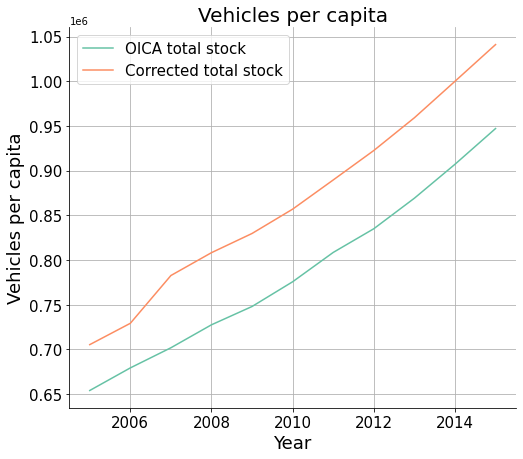

In [46]:
import logging
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)  
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)

ax.plot(ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'].index.values, 
        ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'].values)
ax.plot(ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'].index.values, 
        (ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'] - ius[ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA']['value']+ ldv_corr['value']/1000).dropna())
ax.set_ylabel('Vehicles per capita',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
#warnings.filterwarnings("ignore")
top.set_visible(False)
plt.grid()
ax.legend(['OICA total stock', 'Corrected total stock'], loc='upper left',prop={'size':15})
ax.set_title('Vehicles per capita', fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)


## Calculating historic vehicles per capita

In [47]:
pop_regions_scenarios = pd.read_pickle('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/02_harmonized_data/population_Global/population_UN_regions_scenarios')

In [48]:
pop_regions = pop_regions_scenarios[pop_regions_scenarios.index.get_level_values('Variant')=='Medium']

In [49]:
pop_regions.reset_index(inplace=True)
pop_regions.drop(columns='Variant', inplace=True)
pop_regions.rename({'Location': 'Region', 'Time': 'year', 'PopTotal': 'value'}, axis=1, inplace=True)
pop_regions.set_index(['year', 'Region'], inplace=True)
pop_regions.head()

/var/folders/xm/bmpfd0t11s1g959jbbgj_yz80000gn/T/ipykernel_33904/1999757568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_regions.drop(columns='Variant', inplace=True)
/var/folders/xm/bmpfd0t11s1g959jbbgj_yz80000gn/T/ipykernel_33904/1999757568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_regions.rename({'Location': 'Region', 'Time': 'year', 'PopTotal': 'value'}, axis=1, inplace=True)


,,value
year,Region,
1950,EUROPE,549328.859
1951,EUROPE,554324.506
1952,EUROPE,559694.362
1953,EUROPE,565281.964
1954,EUROPE,570969.740


In [50]:
pop_regions = pop_regions[pop_regions.index.get_level_values('year')<2051]

In [51]:
ius_regions.reset_index(inplace=True)

In [52]:
gl_ius = ius_regions.groupby('year').sum()
gl_ius['REGIONS/COUNTRIES'] = 'GLOBAL'

In [53]:
ius_regions.set_index('year', inplace=True)

In [54]:
ius_regions = pd.concat([ius_regions, gl_ius])

In [55]:
ius_regions.rename(columns= {'REGIONS/COUNTRIES':'Region'}, inplace=True)
ius_regions.reset_index(inplace=True)
ius_regions.rename(columns= {'index':'year'}, inplace=True)
ius_regions.set_index(['year', 'Region'], inplace=True)

In [56]:
ius_regions.head()

,,value
year,Region,
2005,SOUTH KOREA AND JAPAN,68213
2006,SOUTH KOREA AND JAPAN,69128.0
2007,SOUTH KOREA AND JAPAN,69724.0
2008,SOUTH KOREA AND JAPAN,70349.0
2009,SOUTH KOREA AND JAPAN,71044.0


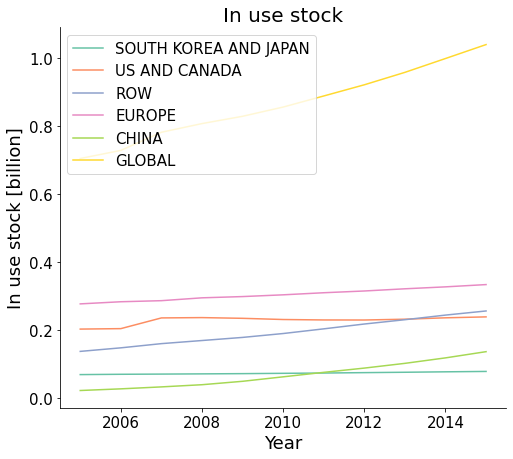

In [60]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(ius_regions.index.get_level_values('Region').unique()):
    ax.plot(ius_regions[ius_regions.index.get_level_values('Region')==r].index.get_level_values('year').values, 
            ius_regions[ius_regions.index.get_level_values('Region')==r].value.values/1e6)
    ax.set_ylabel('In use stock [billion]',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(ius_regions.index.get_level_values('Region').unique(), loc='upper left',prop={'size':15})
    ax.set_title('In use stock', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    fig.savefig(os.getcwd() + '/results/SI/in_use_stock.pdf', dpi=600)


In [61]:
vpc_regions = ius_regions / pop_regions
vpc_regions.dropna(inplace=True)

In [62]:
vpc_regions.reset_index(inplace=True)
vpc_regions.set_index('year', inplace=True)

In [63]:
vpc_regions_sorted = vpc_regions.sort_values('value', ascending=False)

In [64]:
vpc_regions.head()

,Region,value
year,,
2005,CHINA,0.016024
2005,EUROPE,0.37936
2005,GLOBAL,0.107794
2005,ROW,0.034347
2005,SOUTH KOREA AND JAPAN,0.385325


In [65]:
pop_regions.head()

,,value
year,Region,
1950,EUROPE,549328.859
1951,EUROPE,554324.506
1952,EUROPE,559694.362
1953,EUROPE,565281.964
1954,EUROPE,570969.740


In [66]:
vpc_regions.to_excel('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/02_harmonized_data/VpC_Global_2019_2050/VpC_historic_OICA.xlsx')

## Plotting the results

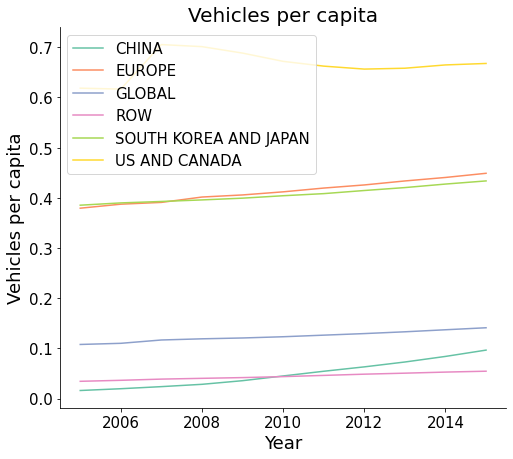

In [68]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(vpc_regions['Region'].unique()):
    ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
            vpc_regions[vpc_regions['Region']==r].value.values)
    ax.set_ylabel('Vehicles per capita',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(vpc_regions['Region'].unique(), loc='upper left',prop={'size':15})
    ax.set_title('Vehicles per capita', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.getcwd() + '/results/SI/vpc.pdf', dpi=600)



In [69]:
vpc_regions.to_excel('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/03_scenario_data/global_model/IUS/vpc_regionalized.xlsx')

## Fitting functions for the baseline

In [70]:
t = np.arange(1950,2051)
vpc_fit = np.zeros((Nr, Nt))
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    popt, pcov = curve_fit(logistic, vpc_regions[vpc_regions['Region']==r].index.values, vpc_regions[vpc_regions['Region']==r].value.values, bounds=([min(vpc_regions[vpc_regions['Region']==r].index.values), 0., 0.01, 0.], [max(vpc_regions[vpc_regions['Region']==r].index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    vpc_fit[i,:] = logistic(t, *popt)


/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Coding/Global_LIB_system/data_handling/fitting_and_preparation/logistic.py:14: RuntimeWarning: overflow encountered in exp
  return (C1 - C0) / (1 + np.exp(-(x - ti) / tau)) + C0


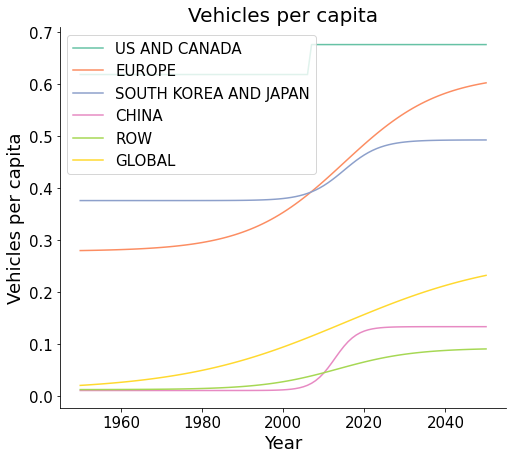

In [71]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    ax.plot(t, 
            vpc_fit[i,:])
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
     #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Vehicles per capita',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items, loc='upper left',prop={'size':15})
    ax.set_title('Vehicles per capita', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)

## Creating VpC scenarios 

In [72]:
scen = pd.read_excel('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/03_scenario_data/global_model/IUS/vpc_regionalized_scenarios.xlsx')
scen.tail()

,year,Region,value,scenario
211,2050,EUROPE,0.70,High
212,2050,GLOBAL,0.60,High
213,2050,ROW,0.40,High
214,2050,SOUTH KOREA AND JAPAN,0.70,High
215,2050,US AND CANADA,0.75,High


In [73]:
# Creating scenarios
vpc_scenarios = np.zeros((Nz,Nr,  Nt))
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
        for j,z in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items):
                popt, pcov = curve_fit(logistic, scen[(scen['Region']==r)&(scen['scenario']==z)].year.values, scen[(scen['Region']==r)&(scen['scenario']==z)].value.values, bounds=([min(scen[(scen['Region']==r)&(scen['scenario']==z)].year.values), 0, 0.01, 0.], [max(scen[(scen['Region']==r)&(scen['scenario']==z)].year.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])                
                vpc_scenarios[j,i,:] = logistic(t, *popt)
                


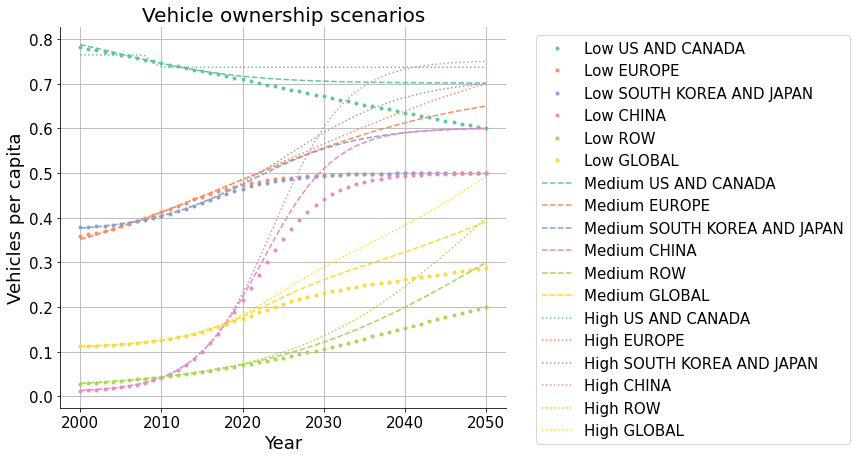

In [92]:
custom_cycler = cycler(color=sns.color_palette('Set2', 11)) #'Set2', 'Paired', 'YlGnBu'
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for j, o in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items):
    ax.set_prop_cycle(custom_cycler)
    for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
        if j ==0:
            ax.plot(t[50:], 
                    vpc_scenarios[j,i,50:], '.', label=f'{o} {r}')
        if j ==1:
            ax.plot(t[50:], 
                    vpc_scenarios[j,i,50:], '--', label=f'{o} {r}')
        if j ==2:
            ax.plot(t[50:], 
                    vpc_scenarios[j,i,50:], ':', label=f'{o} {r}')
ax.set_ylabel('Vehicles per capita',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
plt.grid()
ax.set_title('Vehicle ownership scenarios', fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend( loc='upper left',prop={'size':15}, bbox_to_anchor =(1.05, 1))
fig.savefig(os.getcwd() + '/results/SI/vpc_scenarios.pdf', dpi=600, bbox_inches='tight')


In [75]:
# Calculating global vpc as weighted average from regions
weight = pop_regions.reset_index()
weight.set_index('year', inplace=True)
weight.head()

,Region,value
year,,
1950,EUROPE,549328.859
1951,EUROPE,554324.506
1952,EUROPE,559694.362
1953,EUROPE,565281.964
1954,EUROPE,570969.740


In [76]:
eu =  pd.DataFrame(weight[weight['Region']=='EUROPE'].value / weight[weight['Region']=='GLOBAL'].value)
eu['REGION'] = 'EUROPE'
ch=  pd.DataFrame(weight[weight['Region']=='CHINA'].value / weight[weight['Region']=='GLOBAL'].value)
ch['REGION'] = 'CHINA'
skj =  pd.DataFrame(weight[weight['Region']=='SOUTH KOREA AND JAPAN'].value / weight[weight['Region']=='GLOBAL'].value)
skj['REGION'] = 'SOUTH KOREA AND JAPAN'
usc =  pd.DataFrame(weight[weight['Region']=='US AND CANADA'].value / weight[weight['Region']=='GLOBAL'].value)
usc['REGION'] = 'US AND CANADA'
row =  pd.DataFrame(weight[weight['Region']=='ROW'].value / weight[weight['Region']=='GLOBAL'].value)
row['REGION'] = 'ROW'

In [77]:
weight = pd.concat([eu, ch, skj, usc, row])

In [78]:
weight.head()

,value,REGION
year,,
1950,0.216576,EUROPE
1951,0.214519,EUROPE
1952,0.212742,EUROPE
1953,0.211114,EUROPE
1954,0.209542,EUROPE


In [79]:
IndexTable.Classification[IndexTable.index.get_loc('Region')].Items

['US AND CANADA', 'EUROPE', 'SOUTH KOREA AND JAPAN', 'CHINA', 'ROW', 'GLOBAL']

In [80]:
# Updating Global scenarios
for j in range(3):
    vpc_scenarios[j,5,:] = weight[weight['REGION']=='US AND CANADA'].value.values * vpc_scenarios[j,0,:] + weight[weight['REGION']=='EUROPE'].value.values * vpc_scenarios[j,1,:] + weight[weight['REGION']=='SOUTH KOREA AND JAPAN'].value.values * vpc_scenarios[j,2,:]+ weight[weight['REGION']=='CHINA'].value.values * vpc_scenarios[j,3,:]+ weight[weight['REGION']=='ROW'].value.values * vpc_scenarios[j,4,:]
    

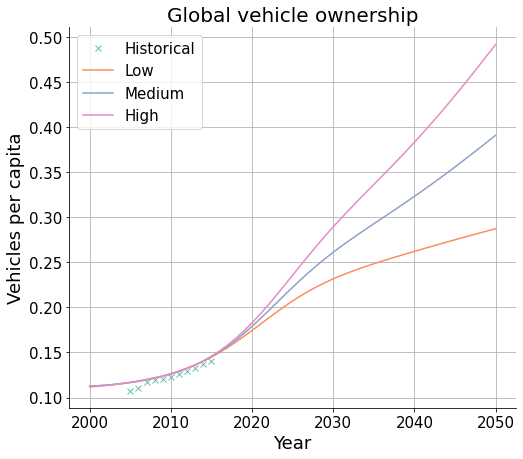

In [90]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(vpc_regions[vpc_regions['Region']=='GLOBAL'].index.values, 
            vpc_regions[vpc_regions['Region']=='GLOBAL'].value.values, 'x')
for j, o in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items):
    ax.plot(t[50:], 
            vpc_scenarios[j,5,50:])
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
    #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Vehicles per capita',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(['Historical'] + IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items, loc='upper left',prop={'size':15})
    ax.set_title('Global vehicle ownership', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.getcwd() + '/results/SI/global_vpc.pdf', dpi=600)


## Calculating total stocks per region

In [93]:
vpc = pd.DataFrame(vpc_fit, index=vpc_regions['Region'].unique())

In [94]:
vpc.reset_index(inplace=True)

In [95]:
time = np.arange(1950,2051)
for i in range(101):
    vpc.rename(columns={i: time[i], 'index':'Region'}, inplace=True)


In [96]:
vpc = vpc.melt('Region')

In [97]:
pop_regions.reset_index(inplace=True)

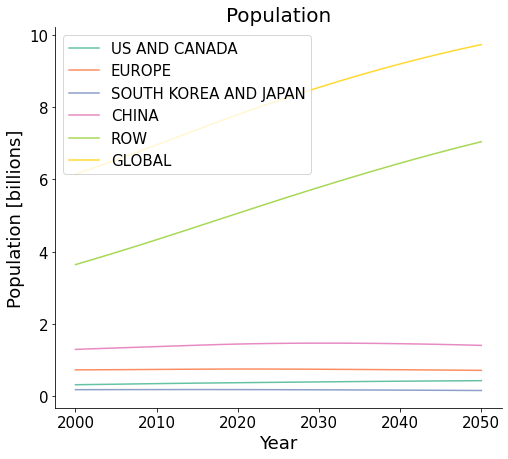

In [98]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    ax.plot(pop_regions[pop_regions['Region']==r].year.values[50:], 
            pop_regions[pop_regions['Region']==r].value.values[50:]/1000000)
            
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
     #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Population [billions]',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items, loc='upper left',prop={'size':15})
    ax.set_title('Population', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.getcwd() + '/results/SI/population.pdf', dpi=600)


In [99]:
PopArray = np.zeros((Nr, Nt))
for m in range(0,len(pop_regions.value.values)):
    #ScenPosition = TODO: Add population scenario to indexes
    RegionPosition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index(pop_regions['Region'].iloc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(pop_regions['year'].iloc[m])
    PopArray[RegionPosition, Timeposition] = pop_regions['value'].iloc[m]

In [100]:
StockArray = np.zeros(( Nz, Nr, Nt))
StockArray[:,:,:] = np.einsum('rt,ort->ort', PopArray*1000, vpc_scenarios)

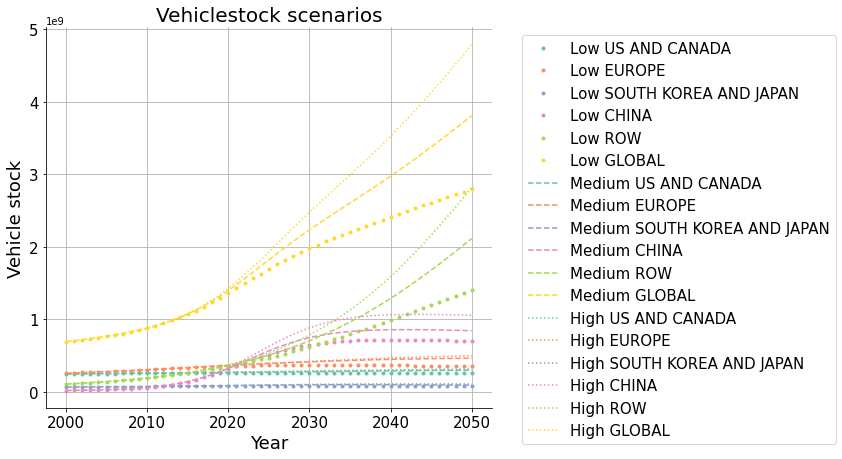

In [102]:
custom_cycler = cycler(color=sns.color_palette('Set2', 11)) #'Set2', 'Paired', 'YlGnBu'
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for j, o in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items):
    ax.set_prop_cycle(custom_cycler)
    for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
        if j ==0:
            ax.plot(t[50:], 
                    StockArray[j,i,50:], '.', label=f'{o} {r}')
        if j ==1:
            ax.plot(t[50:], 
                    StockArray[j,i,50:], '--', label=f'{o} {r}')
        if j ==2:
            ax.plot(t[50:], 
                    StockArray[j,i,50:], ':', label=f'{o} {r}')
ax.set_ylabel('Vehicle stock',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
plt.grid()
ax.set_title('Vehiclestock scenarios', fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend( loc='upper left',prop={'size':15}, bbox_to_anchor =(1.05, 1))
fig.savefig(os.getcwd() + '/results/SI/stock_scenarios.pdf', dpi=600, bbox_inches='tight')


In [103]:
# We only use the baseline population scenario and all defined ownership scenarios
StockArray = np.zeros(( Nz, Nr, Nt))
StockArray[:,:,:] = np.einsum('rt,ort->ort', PopArray*1000, vpc_scenarios)
np.save('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/03_scenario_data/global_model/IUS/regionalized_IUS_OICA_new.npy', StockArray)

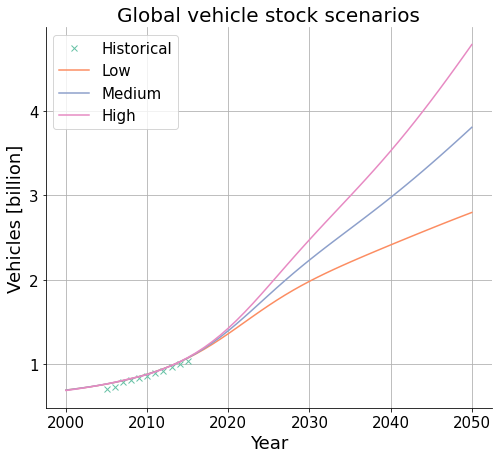

In [104]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(ius_regions[ius_regions.index.get_level_values('Region')=='GLOBAL'].index.get_level_values('year').values, 
            ius_regions[ius_regions.index.get_level_values('Region')=='GLOBAL'].value.values/1000000, 'x')
ax.plot(t[50:], 
        np.moveaxis(StockArray[:,5,50:]/1000000000, 0,1))
ax.set_ylabel('Vehicles [billion]',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
plt.grid()
ax.legend(['Historical'] + IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items, loc='upper left',prop={'size':15})
ax.set_title('Global vehicle stock scenarios', fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.getcwd() + '/results/SI/model_stock_scenarios.pdf', dpi=600, bbox_inches='tight')


NameError: name 'vpc_scen' is not defined

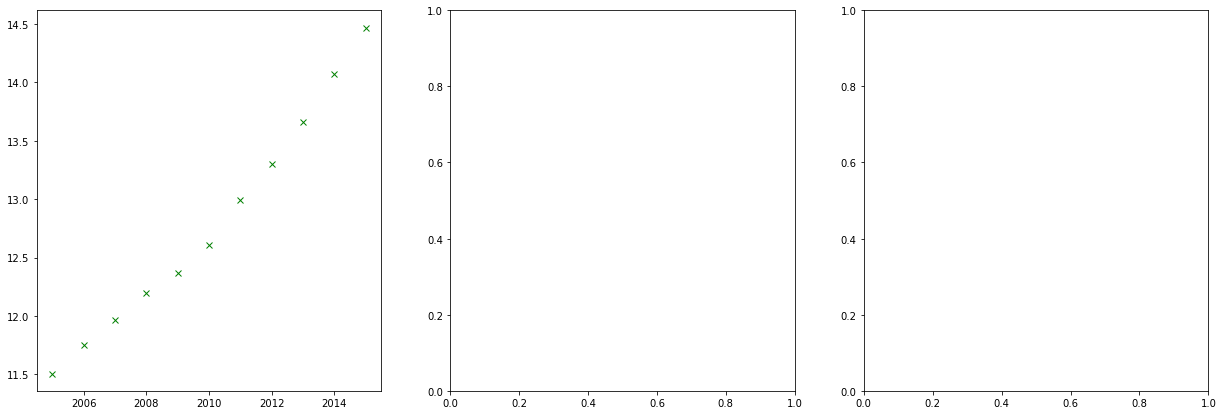

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].plot(vpc_regions[vpc_regions['Region']=='GLOBAL'].index.values, 
            vpc_regions[vpc_regions['Region']=='GLOBAL'].value.values*100, 'gx')
ax[0].plot(t[50:], 
            vpc_scen[1,5,50:]*100, 'limegreen')
ax[0].set_ylabel('Vehicles per capita [%]',fontsize =18)
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top = ax[0].spines["top"]
top.set_visible(False)
ax[0].legend(['Historical data', 'Baseline vehicle per capita projection'], loc='upper left',prop={'size':15})
ax[0].set_title('Global vehicle ownership per capita', fontsize=20)
ax[0].set_xlabel('Year',fontsize =18)
ax[0].set_ylim([0, 30])
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()

ax[1].plot(pop_regions[pop_regions['Region']=='GLOBAL'].year.values[50:], 
            pop_regions[pop_regions['Region']=='GLOBAL'].value.values[50:]/1000000, 'r')
ax[1].set_ylabel('Population [billion]',fontsize =18)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
top = ax[1].spines["top"]
top.set_visible(False)
plt.grid()
#ax[1].legend(['Baseline stock projection', 'Historical data'], loc='upper left',prop={'size':15})
ax[1].set_title('Global population - UN projection', fontsize=20)
ax[1].set_xlabel('Year',fontsize =18)
ax[1].set_ylim([0, 14])
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].grid()


ax[2].set_prop_cycle(custom_cycler)
ax[2].plot(ius_regions[ius_regions.index.get_level_values('Region')=='GLOBAL'].index.get_level_values('year').values, 
            ius_regions[ius_regions.index.get_level_values('Region')=='GLOBAL'].value.values/1000000, 'x')
ax[2].plot(t[50:], 
        StockArray[1,5,50:]/1000000000)
ax[2].set_ylabel('Vehicles [billion]',fontsize =18)
right_side = ax[2].spines["right"]
right_side.set_visible(False)
top = ax[2].spines["top"]
top.set_visible(False)
ax[2].grid()
ax[2].legend([ 'Historical data', 'Baseline vehicle stock projection'], loc='upper left',prop={'size':15})
ax[2].set_title('Global vehicle stock', fontsize=20)
ax[2].set_xlabel('Year',fontsize =18)
ax[2].set_ylim([0, 2.5])
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[2].grid()
#fig.savefig('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Coding/product_component_model/figures/stock_parameters.pdf', dpi=600)


In [ ]:
vpc_scen[1,5,61:]*100

array([12.97522922, 13.31550305, 13.67926745, 14.05990076, 14.44935963,
       14.8388185 , 15.21945175, 15.58321608, 15.92348981, 16.23546969,
       16.51629241, 16.76491294, 16.98181342, 17.16862846, 17.32776118,
       17.4620414 , 17.57445178, 17.66792863, 17.74523075, 17.80886408,
       17.86104789, 17.90370973, 17.93849873, 17.96680909, 17.98980856,
       18.00846788, 18.02358927, 18.03583252, 18.04573822, 18.05374795,
       18.06022151, 18.06545151, 18.06967552, 18.07308617, 18.07583954,
       18.07806192, 18.07985547, 18.0813028 , 18.08247062, 18.08341287])